# CH14 Deep Computer Vision Using Convolutional Neural Networks

In [24]:
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Convolutional Layers

In [7]:
from sklearn.datasets import load_sample_images

images = load_sample_images()['images']
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255)(images)

print(images.shape)

(2, 70, 120, 3)


In [11]:
tf.reduce_max(images[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [17]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',activation='relu')
fmaps = conv_layer(images)
print(fmaps.shape)

(2, 70, 120, 32)


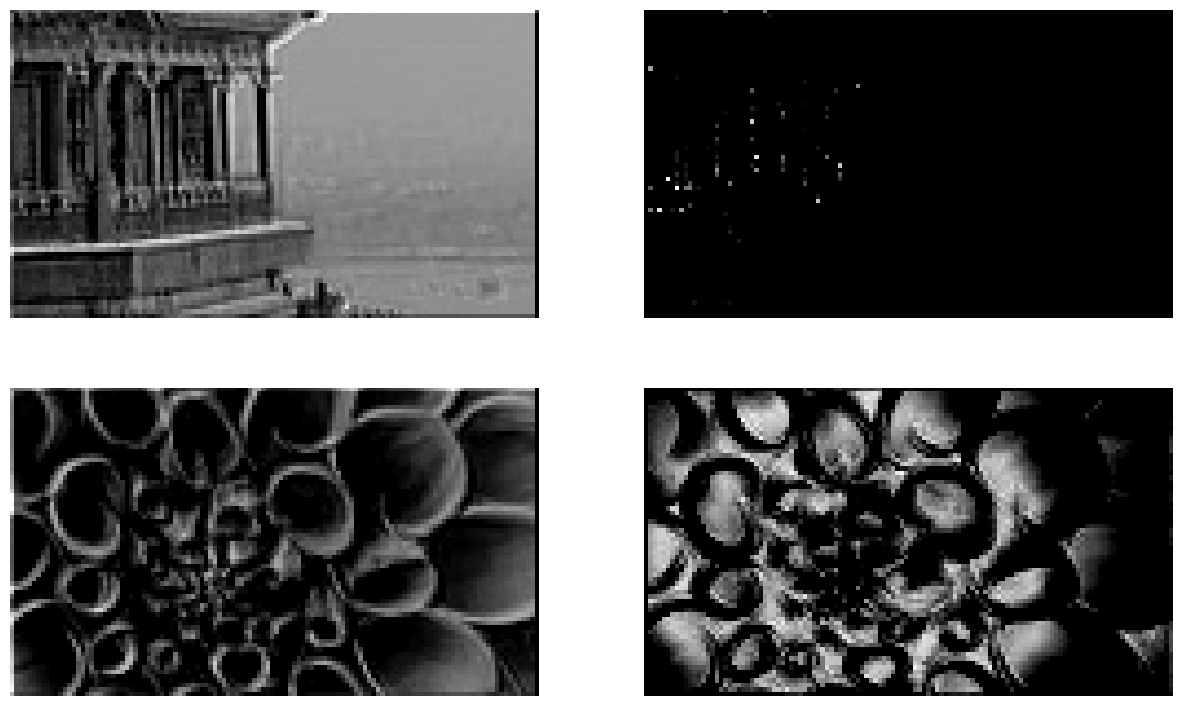

In [18]:
# extra code – displays the two output feature maps for each image

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [20]:
# using strides

conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [22]:
kernels, biases = conv_layer.get_weights()
kernels.shape, biases.shape

((7, 7, 3, 32), (32,))

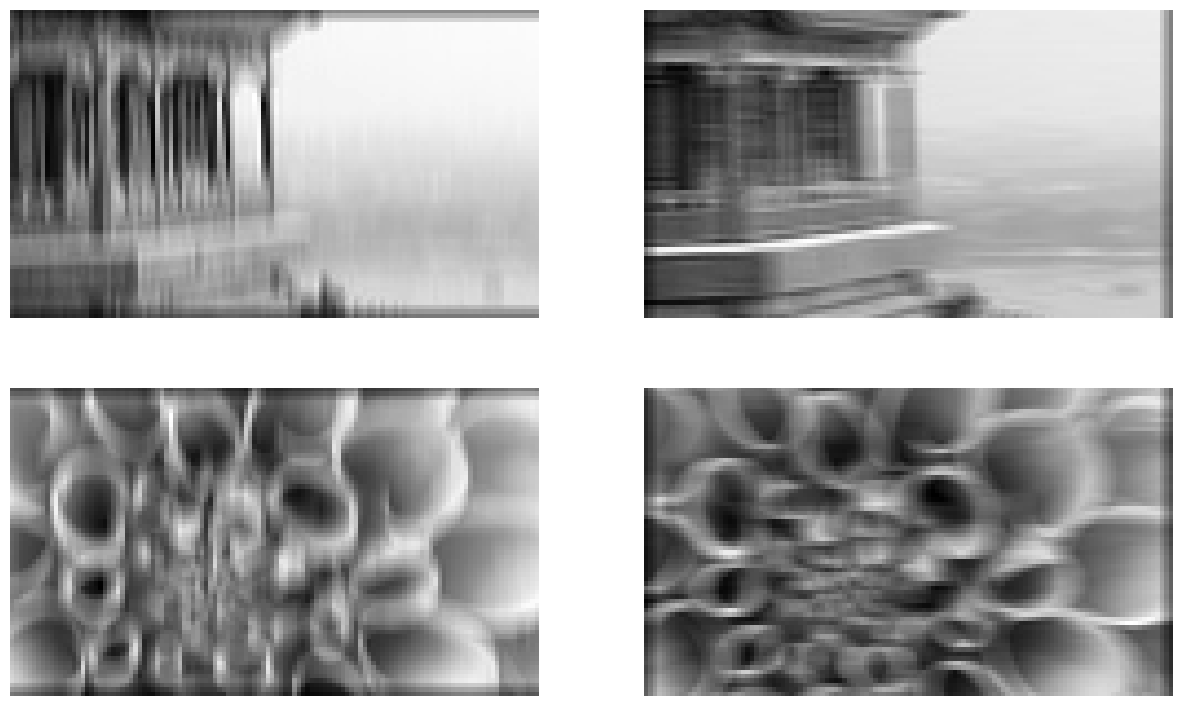

In [26]:
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

### Pooling Layers

In [27]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [28]:
output = max_pool(images)

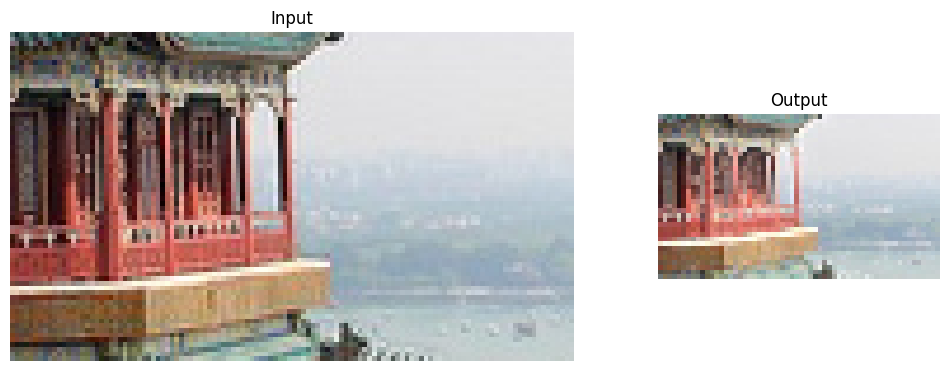

In [29]:
import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [30]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

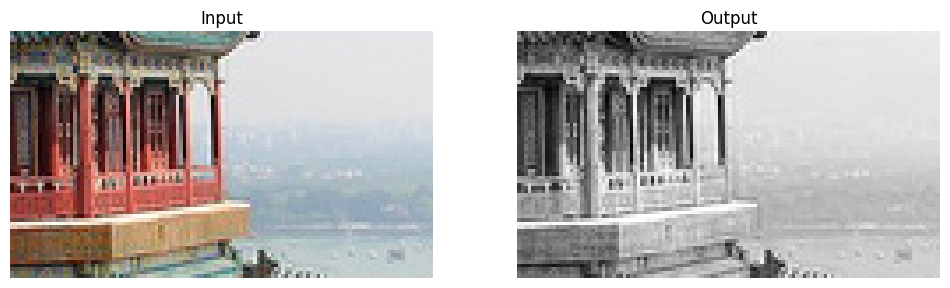

In [31]:
depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

In [32]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
# the same as
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.26010972, 0.10848834]], dtype=float32)>

----